# 훈련 모델 예측 시각화

In [1]:
# -*- coding: utf-8 -*-
import os,sys
sys.path.append(os.getcwd())
import torch
from model.unet_model import Ringed_Res_Unet,DCT_RRUnet # 사용 모델
from dataset.Defacto import * # defacto 데이터셋 한정 테스트 모듈
import torch.nn.functional as F
import torch.nn as nn
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
#________________________________

import torchvision.transforms as transforms


In [9]:
dct_rrunet = DCT_RRUnet().cuda()
dct_rrunet.load_state_dict(torch.load('./result/logs/defactor/DCT_RRUnet/'+
'\DCT-[val_dice]-0.8828-[train_loss]-0.1131-ep2.pkl')) 
rru_net = Ringed_Res_Unet().cuda()
rru_net.load_state_dict(torch.load('./result/logs/defactor/Ringed_Res_Unet/'+
'\defactor-[val_dice]-0.7546-[train_loss]-0.3125-ep15.pkl')) 


<All keys matched successfully>

In [10]:
INDEX =  1333# 1333
MODE = 'te1st' # 'any' : no purmute , no normalize / 'test' same 'train' condition
DIR_IMG = r"E:\splicing_3_img\img_jpg"
DIR_MASK = r"E:\splicing_3_annotations\probe_mask"
IMG_SIZE = 512

def plot_result(model,name):
    device = torch.device("cuda:0")
    if name in "DCT_RRUnet":
        pred,img,mask = test_dct(model,device,INDEX,MODE,IMG_SIZE,DIR_IMG,DIR_MASK)
    else:
        pred,img,mask = test(model,device,INDEX,MODE,IMG_SIZE,DIR_IMG,DIR_MASK)
    if MODE not in ['test','train']:
        img = img.permute(1,2,0)
        
    print(img.shape)

    pred = F.sigmoid(pred)

    pred = pred[0,:,:,:]
    pred_ = pred.permute(1,2,0)
    pred_ = pred_.to('cpu').detach().numpy()

    plt.figure(figsize=(10,2))
    plt.subplot(141)
    plt.imshow(img)
    plt.title('Input')
    plt.axis('off')
    plt.subplot(142)
    plt.imshow(pred_>0.5)#,cmap='jet',interpolation='nearest')
    plt.title('Predict')
    plt.axis('off')
    plt.subplot(143)
    plt.imshow(mask)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(144)
    plt.imshow(img)
    plt.imshow(pred_.squeeze(-1) ,alpha=0.6,cmap='jet')
    plt.title('Heatmap')
    plt.colorbar()
    plt.axis('off')
    plt.show()

    torch.where(pred >= .5, pred, torch.zeros_like(pred))\
        .softmax(dim=0)\
        .argmax(dim=0)


c:\Users\zxcas\anaconda3\envs\style\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


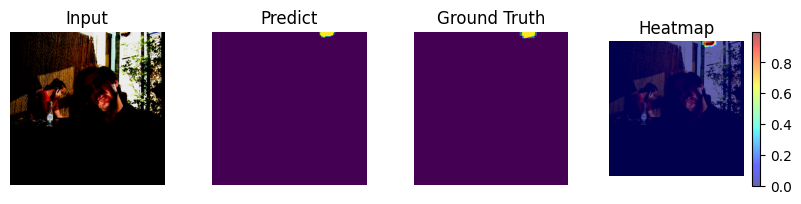

In [11]:
plot_result(dct_rrunet,'DCT')


12000
torch.Size([512, 512, 3])


c:\Users\zxcas\anaconda3\envs\style\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


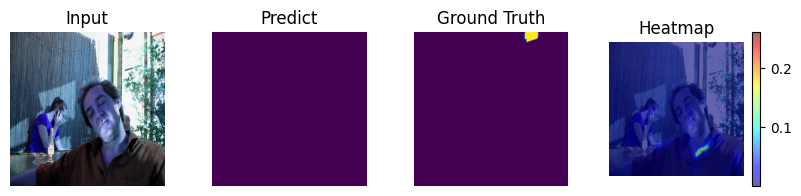

In [12]:
plot_result(rru_net,'rru')

In [107]:
['cat','dog','bird'] # 0 ,1, 2
cat = [1,0,0]
dog = [0,1,0]
bird = [0,0,1]
network = [0.2,0.3,0.5] 
a =np.array(network)
a.argmax(-1)
temp = torch.zeros((2,))
temp[0] = 1
temp

tensor([1., 0.])

False


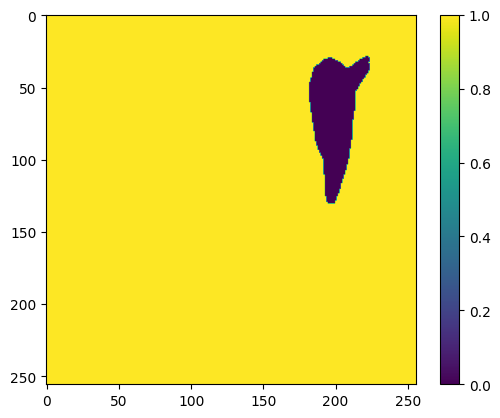

In [102]:
# train.py에 적용 예정
def get_one_hot_encoded_mask(mask_img):    
    y_img = np.squeeze(mask_img, axis=2)
    one_hot_mask = np.zeros((256, 256, 2)) # (W,H,n_classes)

    back = (y_img == 0) # 배경
    object = (y_img > 0)

    one_hot_mask[:, :, 0] = np.where(back, 1, 0) # 배경 레이블
    one_hot_mask[:, :, 1] = np.where(object, 1, 0) # 위조 영역 레이블
    print(one_hot_mask[:, :, 0].tolist() == one_hot_mask[:, :, 1].tolist())
    return one_hot_mask 

m = get_one_hot_encoded_mask(mask)
plt.imshow(m[:,:,0]) # 배경이 1, 정답이 0 이므로 False label / 이미지 위조 탐지 기준 배경을 탐지했으므로 False 임
plt.colorbar()
# plt.close()
# plt.imshow(m[:,:,1]) # 위조 영역 1, 나머지 0 이므로 True label

In [32]:
a = torch.Tensor(np.array([[1,2,3,4,5],[6,7,8,9,10]]))
b = torch.Tensor(np.array([1,2,3,4,5]))
c = torch.Tensor(np.array([2,5,6,7,8]))


image = np.zeros((256,256,3))
label = np.zeros((256,256))

print(image.shape)
label.shape

a = 3
b = 2

a,b = (b,a)
print(a,b)

(256, 256, 3)
2 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


heatmap m n :  tensor(1.8058e-06) tensor(1.)
heatmap m n :  0 255 (256, 256)
heatmap m n :  0 255
im m n :  0.0 1.0


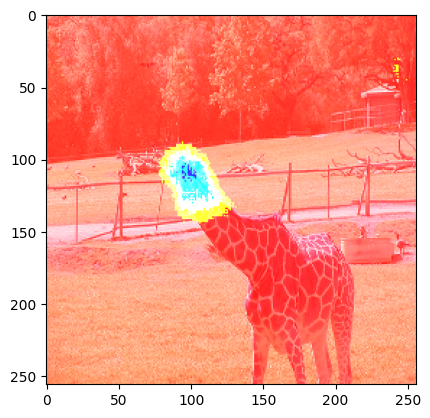

In [12]:
heatmap = torch.mean(pred.to('cpu'), dim=1).squeeze()
heatmap = np.maximum(heatmap, 0)
heatmap /= torch.max(heatmap)
print('heatmap m n : ',heatmap.min(),heatmap.max())
heatmap = np.uint8(heatmap*255)
print('heatmap m n : ',heatmap.min(),heatmap.max(),heatmap.shape)
heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
print('heatmap m n : ',heatmap.min(),heatmap.max())
im = img.numpy()
im = (im-im.min())
im = (im/im.max())

print('im m n : ',im.min(),im.max())
heatmap_img = (heatmap*0.4 + im)
# cv.imshow('Jet',heatmap_img)
# cv.waitKey(0)
# cv.destroyAllWindows()
plt.imshow(heatmap_img)
plt.show()

In [ ]:
from torchsummary import summary
summary(rru_net,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
         GroupNorm-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
         GroupNorm-5         [-1, 32, 256, 256]              64
   RRU_double_conv-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 32, 256, 256]              96
         GroupNorm-8         [-1, 32, 256, 256]              64
              ReLU-9         [-1, 32, 256, 256]               0
           Conv2d-10          [-1, 3, 256, 256]              96
           Conv2d-11         [-1, 32, 256, 256]             896
        GroupNorm-12         [-1, 32, 256, 256]              64
             ReLU-13         [-1, 32, 256, 256]               0
           Conv2d-14         [-1, 32, 2

In [ ]:
print(rru_net)

Ringed_Res_Unet(
  (down): RRU_first_down(
    (conv): RRU_double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): GroupNorm(32, 32, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (4): GroupNorm(32, 32, eps=1e-05, affine=True)
      )
    )
    (relu): ReLU(inplace=True)
    (res_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): GroupNorm(32, 32, eps=1e-05, affine=True)
    )
    (res_conv_back): Sequential(
      (0): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (down1): RRU_down(
    (conv): RRU_double_conv(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (2): ReLU(inpla

In [ ]:
print('# generator parameters:', 1.0 * sum(param.numel() for param in rru_net.parameters())/1000000)
params = list(rru_net.named_parameters())
for i in range(len(params)):
    (name, param) = params[i]
    print(name)
    print(param.shape)
    

# generator parameters: 4.097249
down.conv.conv.0.weight
torch.Size([32, 3, 3, 3])
down.conv.conv.0.bias
torch.Size([32])
down.conv.conv.1.weight
torch.Size([32])
down.conv.conv.1.bias
torch.Size([32])
down.conv.conv.3.weight
torch.Size([32, 32, 3, 3])
down.conv.conv.3.bias
torch.Size([32])
down.conv.conv.4.weight
torch.Size([32])
down.conv.conv.4.bias
torch.Size([32])
down.res_conv.0.weight
torch.Size([32, 3, 1, 1])
down.res_conv.1.weight
torch.Size([32])
down.res_conv.1.bias
torch.Size([32])
down.res_conv_back.0.weight
torch.Size([3, 32, 1, 1])
down1.conv.conv.0.weight
torch.Size([64, 32, 3, 3])
down1.conv.conv.0.bias
torch.Size([64])
down1.conv.conv.1.weight
torch.Size([64])
down1.conv.conv.1.bias
torch.Size([64])
down1.conv.conv.3.weight
torch.Size([64, 64, 3, 3])
down1.conv.conv.3.bias
torch.Size([64])
down1.conv.conv.4.weight
torch.Size([64])
down1.conv.conv.4.bias
torch.Size([64])
down1.res_conv.0.weight
torch.Size([64, 32, 1, 1])
down1.res_conv.1.weight
torch.Size([64])
down1.r

In [27]:
import jpegio
import PIL.Image as Image
import numpy as np

def get_jpeg_info( im_path:str):
        """
        :param im_path: JPEG image path
        :return: DCT_coef (Y,Cb,Cr), qtables (Y,Cb,Cr)
        """
        num_channels =  3#self.DCT_channels
        if im_path[-3:] == "tif":
            print('tiff file')
            outfile = "./test.jpg"
            im = Image.open(im_path)
            out = im.convert("RGB")
            out.save(outfile, "JPEG", quality=90)
        else:
            outfile = "./test.jpg"
        jpeg = jpegio.read(str(outfile))

        # determine which axes to up-sample
        ci = jpeg.comp_info
        need_scale = [[ci[i].v_samp_factor, ci[i].h_samp_factor] for i in range(num_channels)]
        if num_channels == 3:
            if ci[0].v_samp_factor == ci[1].v_samp_factor == ci[2].v_samp_factor:
                need_scale[0][0] = need_scale[1][0] = need_scale[2][0] = 2
            if ci[0].h_samp_factor == ci[1].h_samp_factor == ci[2].h_samp_factor:
                need_scale[0][1] = need_scale[1][1] = need_scale[2][1] = 2
        else:
            need_scale[0][0] = 2
            need_scale[0][1] = 2

        # up-sample DCT coefficients to match image size
        DCT_coef = []
        for i in range(num_channels):
            r, c = jpeg.coef_arrays[i].shape
            coef_view = jpeg.coef_arrays[i].reshape(r//8, 8, c//8, 8).transpose(0, 2, 1, 3)
            # case 1: row scale (O) and col scale (O)
            if need_scale[i][0]==1 and need_scale[i][1]==1:
                out_arr = np.zeros((r * 2, c * 2))
                out_view = out_arr.reshape(r * 2 // 8, 8, c * 2 // 8, 8).transpose(0, 2, 1, 3)
                out_view[::2, ::2, :, :] = coef_view[:, :, :, :]
                out_view[1::2, ::2, :, :] = coef_view[:, :, :, :]
                out_view[::2, 1::2, :, :] = coef_view[:, :, :, :]
                out_view[1::2, 1::2, :, :] = coef_view[:, :, :, :]

            # case 2: row scale (O) and col scale (X)
            elif need_scale[i][0]==1 and need_scale[i][1]==2:
                out_arr = np.zeros((r * 2, c))
                DCT_coef.append(out_arr)
                out_view = out_arr.reshape(r*2//8, 8, c // 8, 8).transpose(0, 2, 1, 3)
                out_view[::2, :, :, :] = coef_view[:, :, :, :]
                out_view[1::2, :, :, :] = coef_view[:, :, :, :]

            # case 3: row scale (X) and col scale (O)
            elif need_scale[i][0]==2 and need_scale[i][1]==1:
                out_arr = np.zeros((r, c * 2))
                out_view = out_arr.reshape(r // 8, 8, c * 2 // 8, 8).transpose(0, 2, 1, 3)
                out_view[:, ::2, :, :] = coef_view[:, :, :, :]
                out_view[:, 1::2, :, :] = coef_view[:, :, :, :]

            # case 4: row scale (X) and col scale (X)
            elif need_scale[i][0]==2 and need_scale[i][1]==2:
                out_arr = np.zeros((r, c))
                out_view = out_arr.reshape(r // 8, 8, c // 8, 8).transpose(0, 2, 1, 3)
                out_view[:, :, :, :] = coef_view[:, :, :, :]

            else:
                raise KeyError("Something wrong here.")

            DCT_coef.append(out_arr)

        # quantization tables
        qtables = [jpeg.quant_tables[ci[i].quant_tbl_no].astype(np.float) for i in range(num_channels)]

        return DCT_coef, qtables

In [ ]:
dct,qtables = get_jpeg_info(r"C:\Users\zxcas\PythonWork\DATASETS\Forgery\copymove_img\img\0_000000000071.tif")
print(dct)
print(qtables)

In [14]:
import cv2 as cv

def cv_convert_test(im_path):
    img = cv.imread(im_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2YCR_CB)
    imf = np.float32(img[0])/255.0  # float conversion/scale
    dct = cv.dct(imf)              # the dct
    imgcv1 = np.uint8(dct*255.0)    # convert back to int
    print(imgcv1.shape)
cv_convert_test(r"C:\Users\zxcas\PythonWork\DATASETS\Forgery\copymove_img\img\0_000000000071.tif")

(640, 3)


In [24]:
import numpy as np
a =np.zeros((20,3,256,256)) # RGB 채널 256x256 이미지 20개 있음 
shape = a[0:5].shape
print(shape)
B,C,H,W = shape
print(B)

(5, 3, 256, 256)
5


In [37]:
import random

def _create_tensor( im_path, mask):
    ignore_index = -1

    img_RGB = np.array(Image.open(im_path).convert("RGB"))

    h, w = img_RGB.shape[0], img_RGB.shape[1]

    if True:
        DCT_coef, qtables = get_jpeg_info(im_path)

    if mask is None:
        mask = np.zeros((h, w))

    if True:
        crop_size = (-(-h//8) * 8, -(-w//8) * 8)  # smallest 8x8 grid crop that contains image
    elif False:
        crop_size = None  # use entire image! no crop, no pad, no DCTcoef or rawRGB
    else:
        crop_size = 0

    if crop_size is not None:
        # Pad if crop_size is larger than image size
        if h < crop_size[0] or w < crop_size[1]:
            # pad img_RGB
            temp = np.full((max(h, crop_size[0]), max(w, crop_size[1]), 3), 127.5)
            temp[:img_RGB.shape[0], :img_RGB.shape[1], :] = img_RGB
            img_RGB = temp

            # pad mask
            temp = np.full((max(h, crop_size[0]), max(w, crop_size[1])), ignore_index)  # pad with ignore_index(-1)
            temp[:mask.shape[0], :mask.shape[1]] = mask
            mask = temp

            # pad DCT_coef
            if True:
                max_h = max(crop_size[0], max([DCT_coef[c].shape[0] for c in range(1)]))
                max_w = max(crop_size[1], max([DCT_coef[c].shape[1] for c in range(1)]))
                for i in range(1):
                    temp = np.full((max_h, max_w), 0.0)  # pad with 0
                    temp[:DCT_coef[i].shape[0], :DCT_coef[i].shape[1]] = DCT_coef[i][:, :]
                    DCT_coef[i] = temp

        # Determine where to crop
        if True:
            s_r = (random.randint(0, max(h - crop_size[0], 0)) // 8) * 8
            s_c = (random.randint(0, max(w - crop_size[1], 0)) // 8) * 8
        else:
            s_r = random.randint(0, max(h - crop_size[0], 0))
            s_c = random.randint(0, max(w - crop_size[1], 0))

        # crop img_RGB
        img_RGB = img_RGB[s_r:s_r+crop_size[0], s_c:s_c+crop_size[1], :]

        # crop mask
        mask = mask[s_r:s_r + crop_size[0], s_c:s_c + crop_size[1]]

        # crop DCT_coef
        if True:
            for i in range(1):
                DCT_coef[i] = DCT_coef[i][s_r:s_r+crop_size[0], s_c:s_c+crop_size[1]]
            t_DCT_coef = torch.tensor(DCT_coef, dtype=torch.float)  # final (but used below)

    # handle 'RGB'
    if 'RGB' in ["RGB"]:
        t_RGB = (torch.tensor(img_RGB.transpose(2,0,1), dtype=torch.float)-127.5)/127.5  # final

    # handle 'DCTvol'
    if 'DCTvol' in ["DCTvol"]:
        T = 20
        t_DCT_vol = torch.zeros(size=(T+1, t_DCT_coef.shape[1], t_DCT_coef.shape[2]))
        t_DCT_vol[0] += (t_DCT_coef == 0).float().squeeze()
        for i in range(1, T):
            t_DCT_vol[i] += (t_DCT_coef == i).float().squeeze()
            t_DCT_vol[i] += (t_DCT_coef == -i).float().squeeze()
        t_DCT_vol[T] += (t_DCT_coef >= T).float().squeeze()
        t_DCT_vol[T] += (t_DCT_coef <= -T).float().squeeze()

    # create tensor
    _blocks = ['DCTcoef','qtable']
    img_block = []
    for i in range(len(_blocks)): # blocks 는 ['RGB','DCTcoef','DCTvol','qtable']
        if _blocks[i] == 'RGB':
            img_block.append(t_RGB)
        elif _blocks[i] == 'DCTcoef':
            img_block.append(t_DCT_coef)
        elif _blocks[i] == 'DCTvol':
            img_block.append(t_DCT_vol)
        elif _blocks[i] == 'qtable':
            continue
        else:
            raise KeyError("We cannot reach here. Something is wrong.")

    # final tensor
    tensor = torch.cat(img_block)

    if 'qtable' not in _blocks:
        return tensor, torch.tensor(mask, dtype=torch.long), 0
    else:
        return tensor, torch.tensor(mask, dtype=torch.long), torch.tensor(qtables[:1], dtype=torch.float)

im_path = './test.jpg'

data = _create_tensor(im_path,None)
a,b,c = data
print(type(a))
print(type(b))
print(type(c))
a.shape

C:\Users\zxcas\AppData\Local\Temp\ipykernel_6264\861269628.py:74: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  qtables = [jpeg.quant_tables[ci[i].quant_tbl_no].astype(np.float) for i in range(num_channels)]


RuntimeError: output with shape [432, 640] doesn't match the broadcast shape [3, 432, 640]